<a href="https://colab.research.google.com/github/jkworldchampion/Military_CodingStudy/blob/main/deeplearning/basic_deeplearning_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망(CNN)

이번 장의 주제는 합성곱 신경망입니다.  
 CNN은 이미지 인식과 음성 인식 등 다양한 곳에서 사용되는데,   
 특히 이미지 인식 분야에서 딥러닝을 활용한 기법은 대부분 CNN을 기반으로 합니다.   
 이번장에서는 CNN의 매커니즘을 자세히 알아봅시다.

## 7.1 전체 구조
CNN도 지금까지와 같이 레고 블럭처럼 조합하여 만들 수 있습니다. 다만, 합성곱 계층과 풀링계층이 새롭게 등장합니다. 지금까지의 신경망은 인접하는 계층의 모든 뉴런과 결합되어 있습니다. 이를 완전연결(Fully-Connected)이라고 하며, Affine 계층이라는 이름으로 구현했습니다. 완전연결 신경망은 Affine 계층 뒤에 활성화 함수를 갖는 ReLU 계층이 이어집니다.  
즉, 이러한 연결이 Conv-ReLU-(Pooling)가 되었다고 생각하면 됩니다. 

In [40]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
cd /content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/ch07

/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/ch07


In [66]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import *
import pickle
from collections import OrderedDict
from common.gradient import numerical_gradient
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

In [67]:
# im2col 함수 구현해보기
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1   # 출력 크기 구하는 공식
    out_w = (W + 2*pad - filter_w)//stride + 1   

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')   # data를 pad만큼 둘러싼 모양으로 된다. 
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [68]:
filter_h = 5
filter_w = 5
stride = 1
pad = 0


input_data = np.random.rand(1, 3, 7, 7).round(2)
N, C, H, W = input_data.shape
out_h = (H + 2*pad - filter_h)//stride + 1   # 3
out_w = (W + 2*pad - filter_w)//stride + 1   # 3
img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')  # pad-0이기 때문에 원본데이터
col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))  # np.zeros((1, 3, 5, 5, 3, 3))
num = 0
for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            print(num, y_max, x_max)
            num+=1
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]  # col은 필터, img는 전체 이미지
# 여기까지, col은 이미지가 합쳐질 필터를 저장해놓은 공간, img는 전체 이미지 데이터를 저장하는 공간

0 3 3
1 3 4
2 3 5
3 3 6
4 3 7
5 4 3
6 4 4
7 4 5
8 4 6
9 4 7
10 5 3
11 5 4
12 5 5
13 5 6
14 5 7
15 6 3
16 6 4
17 6 5
18 6 6
19 6 7
20 7 3
21 7 4
22 7 5
23 7 6
24 7 7


In [69]:
# 행렬에 대한 transpose() 함수에 대한 고찰
test_col = np.arange(24).reshape(2, 3, 4)
print(test_col)
print("---------------------")
print(test_col.transpose(0, 2, 1))
print("---------------------")
print(test_col.transpose(2, 1, 0))
# 그림과 함께 보고싶다면 "https://jimmy-ai.tistory.com/207"

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]
---------------------
[[[ 0  4  8]
  [ 1  5  9]
  [ 2  6 10]
  [ 3  7 11]]

 [[12 16 20]
  [13 17 21]
  [14 18 22]
  [15 19 23]]]
---------------------
[[[ 0 12]
  [ 4 16]
  [ 8 20]]

 [[ 1 13]
  [ 5 17]
  [ 9 21]]

 [[ 2 14]
  [ 6 18]
  [10 22]]

 [[ 3 15]
  [ 7 19]
  [11 23]]]


In [70]:
#col_last = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)  # 이 줄이 어떻게 동작하나 알아보자
print(col.shape) # 우선 원래의 행렬
print(col.transpose(0, 4, 5, 1, 2, 3).shape) # 바뀐 행렬 (1, 3, 3, 3, 5, 5)로 바뀜
print(col.reshape(N*out_h*out_w, -1))  # N*out_h*out_w 의 숫자와 , 나머지 남은 수

(1, 3, 5, 5, 3, 3)
(1, 3, 3, 3, 5, 5)
[[0.4  0.08 0.44 0.63 0.88 0.62 0.84 0.23 0.53 0.08 0.44 0.99 0.88 0.62
  0.86 0.23 0.53 0.13 0.44 0.99 0.52 0.62 0.86 0.19 0.53 0.13 0.23 0.99
  0.52 0.66 0.86 0.19 0.35 0.13 0.23 0.76 0.52 0.66 0.05 0.19 0.35 0.73
  0.23 0.76 0.12 0.63 0.88 0.62 0.84 0.23 0.53 0.12 0.65 0.69 0.88 0.62
  0.86 0.23 0.53 0.13 0.65 0.69 0.82 0.62 0.86 0.19 0.53 0.13 0.23 0.69
  0.82 0.11 0.86 0.19 0.35]
 [0.13 0.23 0.76 0.82 0.11 0.   0.19 0.35 0.73 0.23 0.76 0.12 0.11 0.
  0.61 0.84 0.23 0.53 0.12 0.65 0.69 0.2  0.98 0.14 0.23 0.53 0.13 0.65
  0.69 0.82 0.98 0.14 0.93 0.53 0.13 0.23 0.69 0.82 0.11 0.14 0.93 0.03
  0.13 0.23 0.76 0.82 0.11 0.   0.93 0.03 0.18 0.23 0.76 0.12 0.11 0.
  0.61 0.03 0.18 0.9  0.12 0.65 0.69 0.2  0.98 0.14 0.12 0.8  0.1  0.65
  0.69 0.82 0.98 0.14 0.93]
 [0.8  0.1  0.29 0.69 0.82 0.11 0.14 0.93 0.03 0.1  0.29 0.5  0.82 0.11
  0.   0.93 0.03 0.18 0.29 0.5  0.49 0.11 0.   0.61 0.03 0.18 0.9  0.5
  0.49 0.35 0.2  0.98 0.14 0.12 0.8  0.1  0.2  

In [71]:
# im2col사용해 행렬 펼치기
from common.util import im2col
x1 = np.random.rand(1, 3, 7, 7).round(2)
print(x1.shape)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

(1, 3, 7, 7)
(9, 75)


In [72]:
x2 = np.random.rand(10, 3, 7, 7).round(2)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(90, 75)


이러한 im2col을 갖고, 합성곱 계층을 구현해보기

In [49]:
# 컨볼루션 신경망 구현하기
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 +(H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T  # 필터 전개
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

In [63]:
# 풀링 구현하기
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 전개 (1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        # 최댓값 (2)
        out = np.max(col, axis=1)

        # 성형 (3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

In [73]:
class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28),  # 784
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1  # output size 계산 공식
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))  

        # 가중치 매개변수 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()   # 순서가 있는 딕셔너리
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)
        
        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


train loss:2.299793644481677
=== epoch:1, train acc:0.373, test acc:0.364 ===
train loss:2.2972841636650254
train loss:2.2938666224710715
train loss:2.2841361845338795
train loss:2.2799994150979526
train loss:2.2609564539854365
train loss:2.25370930627701
train loss:2.2341193299857873
train loss:2.2145533380797784
train loss:2.1762455659288684
train loss:2.135684602821615
train loss:2.1095849226808117
train loss:2.0584600142185714
train loss:2.023987412125722
train loss:1.9567390899293196
train loss:1.8964372097596012
train loss:1.810030286602599
train loss:1.6984510944543343
train loss:1.650326426788798
train loss:1.5195735070082907
train loss:1.5445569924549911
train loss:1.450255221236302
train loss:1.2521764064572296
train loss:1.2362741995361577
train loss:1.2264139974295682
train loss:1.0259149221037454
train loss:1.0458306819784386
train loss:1.0509910703145757
train loss:0.9406811367186008
train loss:0.8623919481983434
train loss:0.940622041492469
train loss:0.7139219225446528


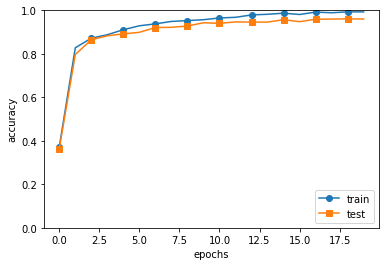

In [74]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

CNN 시각화 하기

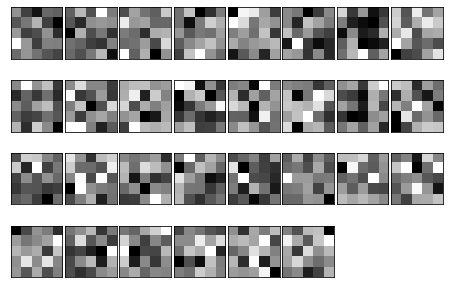

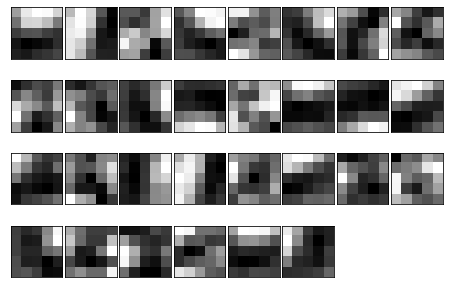

In [75]:
# 1번째 층의 가중치 시각화하기
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])